In [ ]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append("..")
                
import numpy as np
import pandas as pd
#np.random.seed(123)

# viz
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(rc={'figure.figsize':(12.7,10.27)})

# notebook settings
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')

pd.set_option('display.max_columns', 1000)

## Sample Prep

In [3]:
HGNC = pd.read_csv("../../../keiser/data/hgnc_mapping_ids/hgnc.txt", sep="\t")

### Define sample types

In [4]:
from collections import OrderedDict 
hierarchy = OrderedDict({'Project ID':['TCGA-BRCA', 'TCGA-LUAD', 'TCGA-KIRC', 'TCGA-THCA', 'TCGA-PRAD', 'TCGA-SKCM'],
                         'Sample Type':['Primary Tumor', 'Solid Tissue Normal', 'Metastatic']})

In [5]:
from dutils import Experiment, train_test_split_case
exp = Experiment(samples_dir='../../data/TCGA/rna-seq_pan/meta/gdc_sample_sheet.2019-12-12.tsv',
                 hierarchy=hierarchy,
                 cases='Case ID',
                 min_samples=20)
exp.holdout(holdout=['TCGA-SKCM:Metastatic'])

In [6]:
exp.meta_dict

{0: 'TCGA-BRCA:Primary Tumor',
 1: 'TCGA-BRCA:Solid Tissue Normal',
 2: 'TCGA-KIRC:Primary Tumor',
 3: 'TCGA-KIRC:Solid Tissue Normal',
 4: 'TCGA-LUAD:Primary Tumor',
 5: 'TCGA-LUAD:Solid Tissue Normal',
 6: 'TCGA-PRAD:Primary Tumor',
 7: 'TCGA-PRAD:Solid Tissue Normal',
 8: 'TCGA-SKCM:Metastatic',
 9: 'TCGA-SKCM:Primary Tumor',
 10: 'TCGA-THCA:Primary Tumor',
 11: 'TCGA-THCA:Solid Tissue Normal'}

## Dataset Prep

Need to ensure test set has health/diseased samples matched for each case

In [7]:
exp.samples['meta'].value_counts()
exp.holdout_samples['meta'].value_counts()

TCGA-BRCA:Primary Tumor          1087
TCGA-LUAD:Primary Tumor           528
TCGA-KIRC:Primary Tumor           483
TCGA-PRAD:Primary Tumor           466
TCGA-THCA:Primary Tumor           445
TCGA-BRCA:Solid Tissue Normal     112
TCGA-SKCM:Primary Tumor           103
TCGA-KIRC:Solid Tissue Normal      70
TCGA-LUAD:Solid Tissue Normal      58
TCGA-THCA:Solid Tissue Normal      53
TCGA-PRAD:Solid Tissue Normal      50
TCGA-SKCM:Metastatic                0
Name: meta, dtype: int64

TCGA-SKCM:Metastatic             364
TCGA-THCA:Solid Tissue Normal      0
TCGA-THCA:Primary Tumor            0
TCGA-SKCM:Primary Tumor            0
TCGA-PRAD:Solid Tissue Normal      0
TCGA-PRAD:Primary Tumor            0
TCGA-LUAD:Solid Tissue Normal      0
TCGA-LUAD:Primary Tumor            0
TCGA-KIRC:Solid Tissue Normal      0
TCGA-KIRC:Primary Tumor            0
TCGA-BRCA:Solid Tissue Normal      0
TCGA-BRCA:Primary Tumor            0
Name: meta, dtype: int64

In [8]:
from sklearn.preprocessing import StandardScaler

target = 'meta'

train, test = train_test_split_case(exp.samples, cases='Case ID')
# stratification is not quite perfect but close
# in order to preserve matched samples for each case together
# in train or test set
case_counts = exp.samples[target].value_counts()
train[target].value_counts()[case_counts.index.to_numpy()] / case_counts
test[target].value_counts()[case_counts.index.to_numpy()] / case_counts

TCGA-BRCA:Primary Tumor          0.786569
TCGA-LUAD:Primary Tumor          0.829545
TCGA-KIRC:Primary Tumor          0.799172
TCGA-PRAD:Primary Tumor          0.811159
TCGA-THCA:Primary Tumor          0.797753
TCGA-BRCA:Solid Tissue Normal    0.794643
TCGA-SKCM:Primary Tumor          0.776699
TCGA-KIRC:Solid Tissue Normal    0.857143
TCGA-LUAD:Solid Tissue Normal    0.844828
TCGA-THCA:Solid Tissue Normal    0.773585
TCGA-PRAD:Solid Tissue Normal    0.760000
TCGA-SKCM:Metastatic                  NaN
Name: meta, dtype: float64

TCGA-BRCA:Primary Tumor          0.213431
TCGA-LUAD:Primary Tumor          0.170455
TCGA-KIRC:Primary Tumor          0.200828
TCGA-PRAD:Primary Tumor          0.188841
TCGA-THCA:Primary Tumor          0.202247
TCGA-BRCA:Solid Tissue Normal    0.205357
TCGA-SKCM:Primary Tumor          0.223301
TCGA-KIRC:Solid Tissue Normal    0.142857
TCGA-LUAD:Solid Tissue Normal    0.155172
TCGA-THCA:Solid Tissue Normal    0.226415
TCGA-PRAD:Solid Tissue Normal    0.240000
TCGA-SKCM:Metastatic                  NaN
Name: meta, dtype: float64

In [9]:
import torch
from torch.optim import lr_scheduler
import torch.optim as optim
from torch.autograd import Variable
#torch.manual_seed(123)

from trainer import fit
import visualization as vis
import numpy as np
cuda = torch.cuda.is_available()
print("Cuda is available: {}".format(cuda))


Cuda is available: True


In [30]:
from tcga_datasets import TCGA, SiameseTCGA
root_dir = "../../data/TCGA/rna-seq_pan/"

train_dataset = TCGA(root_dir, samples=train, meta_dict=exp.meta_dict, train=True, target=target, log=True)
train_dataset.featurize(HGNC=HGNC, features='all', proteins_only=True)

test_dataset = TCGA(root_dir, samples=test, meta_dict=exp.meta_dict, train=False, target=target, log=True)
test_dataset.featurize(HGNC=HGNC, features='all', proteins_only=True)

Exception ignored in: <function _ConnectionBase.__del__ at 0x7f5a59602378>
Traceback (most recent call last):
  File "/srv/home/wconnell/anaconda3/envs/torch/lib/python3.7/multiprocessing/connection.py", line 132, in __del__
    self._close()
  File "/srv/home/wconnell/anaconda3/envs/torch/lib/python3.7/multiprocessing/connection.py", line 361, in _close
Traceback (most recent call last):
  File "/srv/home/wconnell/anaconda3/envs/torch/lib/python3.7/multiprocessing/queues.py", line 232, in _feed
    close()
  File "/srv/home/wconnell/anaconda3/envs/torch/lib/python3.7/multiprocessing/connection.py", line 177, in close
    self._close()
  File "/srv/home/wconnell/anaconda3/envs/torch/lib/python3.7/multiprocessing/connection.py", line 361, in _close
    _close(self._handle)
OSError: [Errno 9] Bad file descriptor
    _close(self._handle)
OSError: [Errno 9] Bad file descriptor


In [31]:
np.array_equal(train_dataset.data.columns, test_dataset.data.columns)

True

In [32]:
scaler = StandardScaler()
train_dataset.data = pd.DataFrame(scaler.fit_transform(train_dataset.data),
                                  index=train_dataset.data.index,
                                  columns=train_dataset.data.columns)
test_dataset.data = pd.DataFrame(scaler.transform(test_dataset.data),
                                 index=test_dataset.data.index,
                                 columns=test_dataset.data.columns)

In [33]:
train_dataset.data.shape
test_dataset.data.shape

# Still required in order to feed single samples for embedding extraction
batch_size = 1
kwargs = {'num_workers': 10, 'pin_memory': True} if cuda else {'num_workers': 10}
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, **kwargs)

(2769, 19577)

(686, 19577)

## Siamese Network

In [34]:
# Step 1 set up dataloader
siamese_train_dataset = SiameseTCGA(train_dataset) # Returns pairs of images and target same/different
siamese_test_dataset = SiameseTCGA(test_dataset)
batch_size = 8
kwargs = {'num_workers': 10, 'pin_memory': True} if cuda else {'num_workers': 10}
siamese_train_loader = torch.utils.data.DataLoader(siamese_train_dataset, batch_size=batch_size, shuffle=True, **kwargs)
siamese_test_loader = torch.utils.data.DataLoader(siamese_test_dataset, batch_size=batch_size, shuffle=False, **kwargs)

# Set up the network and training parameters
from tcga_networks import EmbeddingNet, SiameseNet
from losses import ContrastiveLoss
from metrics import AccumulatedAccuracyMetric

# Step 2
n_samples, n_features = siamese_train_dataset.data.shape
embedding_net = EmbeddingNet(n_features)
# Step 3
model = SiameseNet(embedding_net)
if cuda:
    model.cuda()
    
# Step 4
margin = 1.
loss_fn = ContrastiveLoss(margin)
lr = 1e-3
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = lr_scheduler.StepLR(optimizer, 8, gamma=0.1, last_epoch=-1)
n_epochs = 1
# print training metrics every log_interval * batch_size
log_interval = round(len(siamese_train_dataset)/4/batch_size)

SiameseNet(
  (embedding_net): EmbeddingNet(
    (fc): Sequential(
      (linear1): Linear(in_features=19577, out_features=2000, bias=True)
      (relu1): PReLU(num_parameters=1)
      (linear2): Linear(in_features=2000, out_features=500, bias=True)
      (relu2): PReLU(num_parameters=1)
      (linear3): Linear(in_features=500, out_features=250, bias=True)
      (relu3): PReLU(num_parameters=1)
      (linear4): Linear(in_features=250, out_features=100, bias=True)
      (relu4): PReLU(num_parameters=1)
      (linear5): Linear(in_features=100, out_features=50, bias=True)
      (relu5): PReLU(num_parameters=1)
      (linear6): Linear(in_features=50, out_features=10, bias=True)
      (relu6): PReLU(num_parameters=1)
      (linear7): Linear(in_features=10, out_features=2, bias=True)
    )
  )
)

In [35]:
train_loss, val_loss = fit(siamese_train_loader, siamese_test_loader, model, loss_fn, optimizer, scheduler, 
    n_epochs, cuda, log_interval)

Train: [0/2769 (0%)]	Loss: 0.309824
Train: [696/2769 (25%)]	Loss: 0.126705
Train: [1392/2769 (50%)]	Loss: 0.081006
Train: [2088/2769 (75%)]	Loss: 0.086897
Epoch: 1/1. Train set: Average loss: 0.0856
Epoch: 1/1. Validation set: Average loss: 0.0372


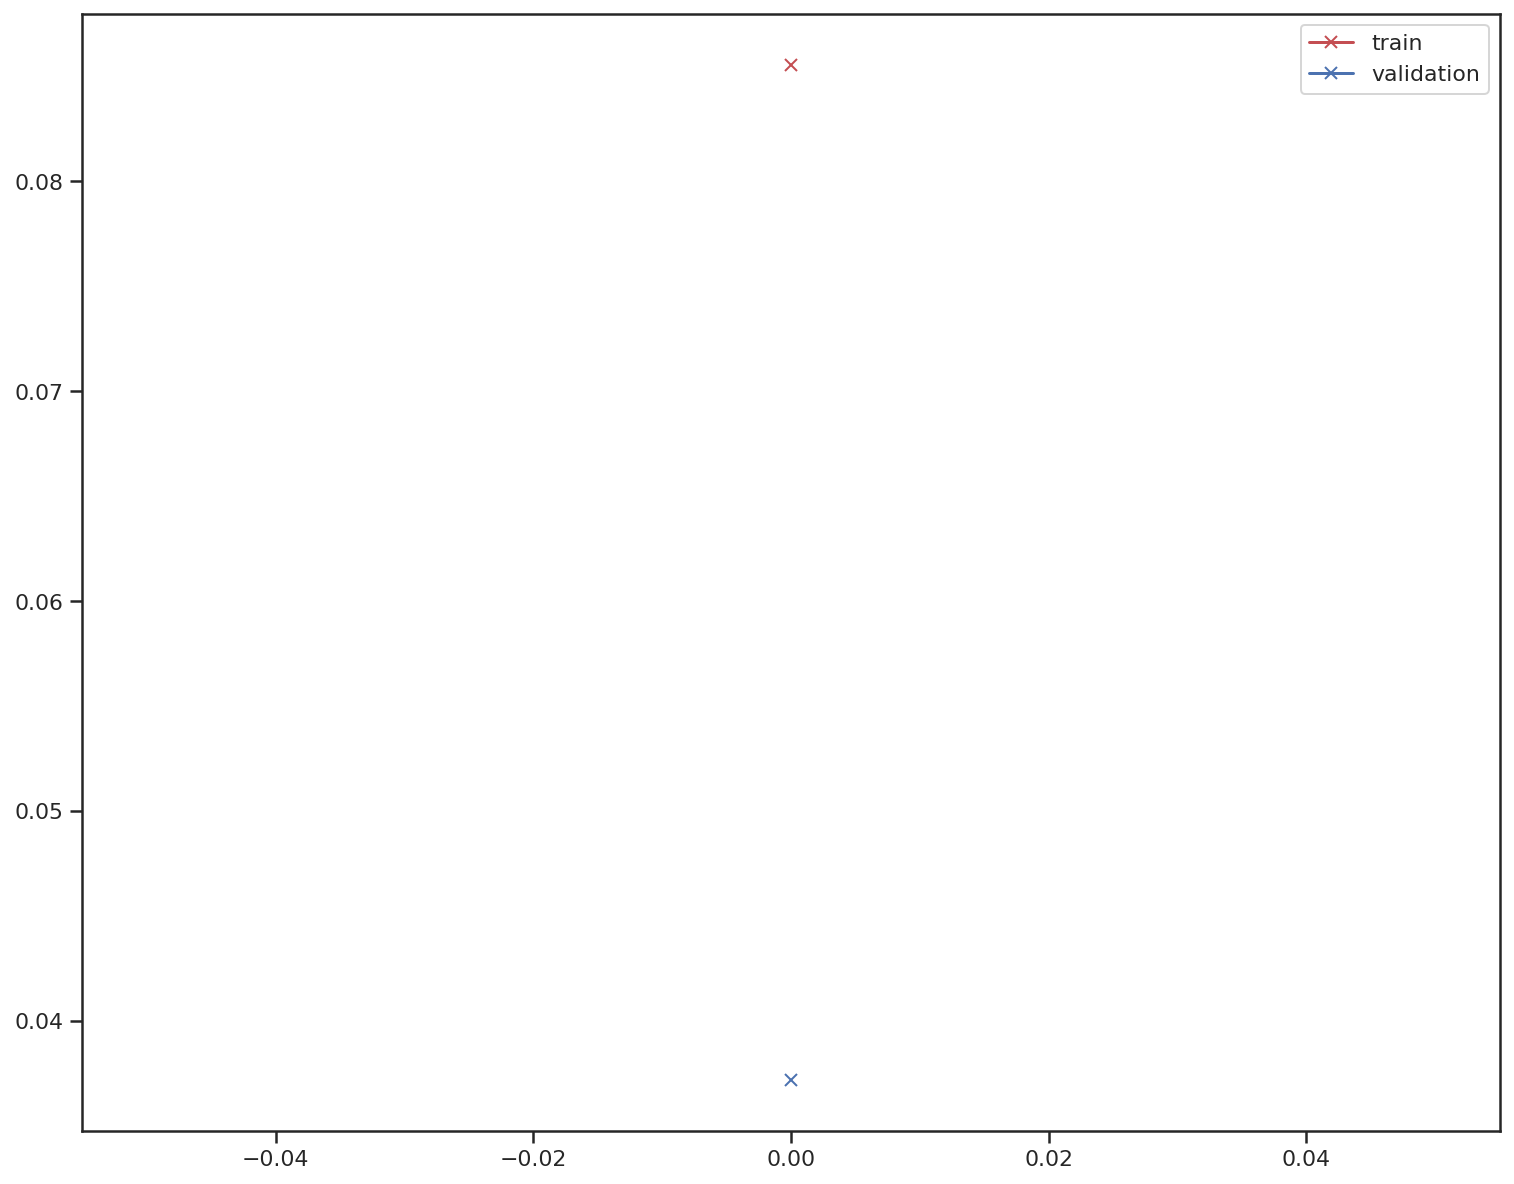

In [36]:
plt.plot(range(0, n_epochs), train_loss, 'rx-', label='train')
plt.plot(range(0, n_epochs), val_loss, 'bx-', label='validation')
plt.legend()

Text(0.5, 1.0, 'PanCancer Train: Siamese')

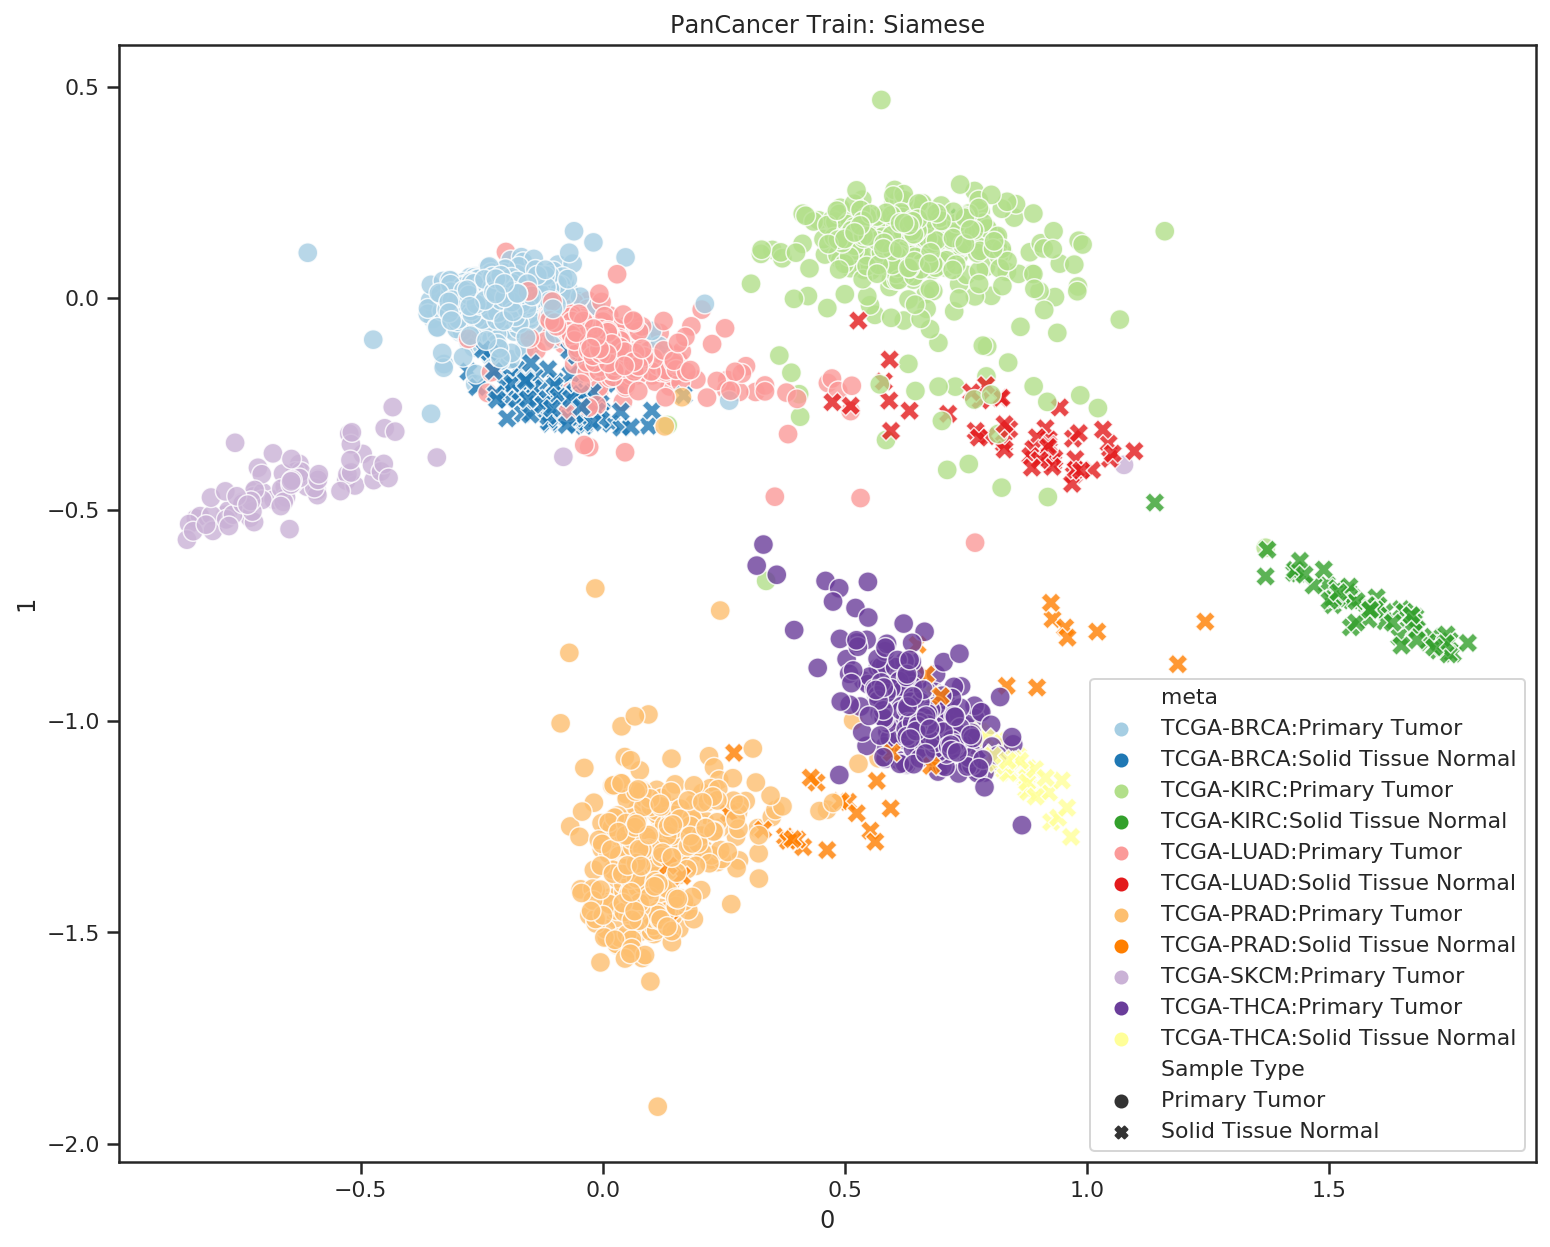

In [37]:
train_embeddings_cl, train_labels_cl = vis.extract_embeddings(train_loader, model)
vis.sns_plot_embeddings(train_embeddings_cl, train_labels_cl, siamese_train_dataset, hue='meta', style='Sample Type')
plt.title('PanCancer Train: Siamese')

Text(0.5, 1.0, 'PanCancer Test: Siamese')

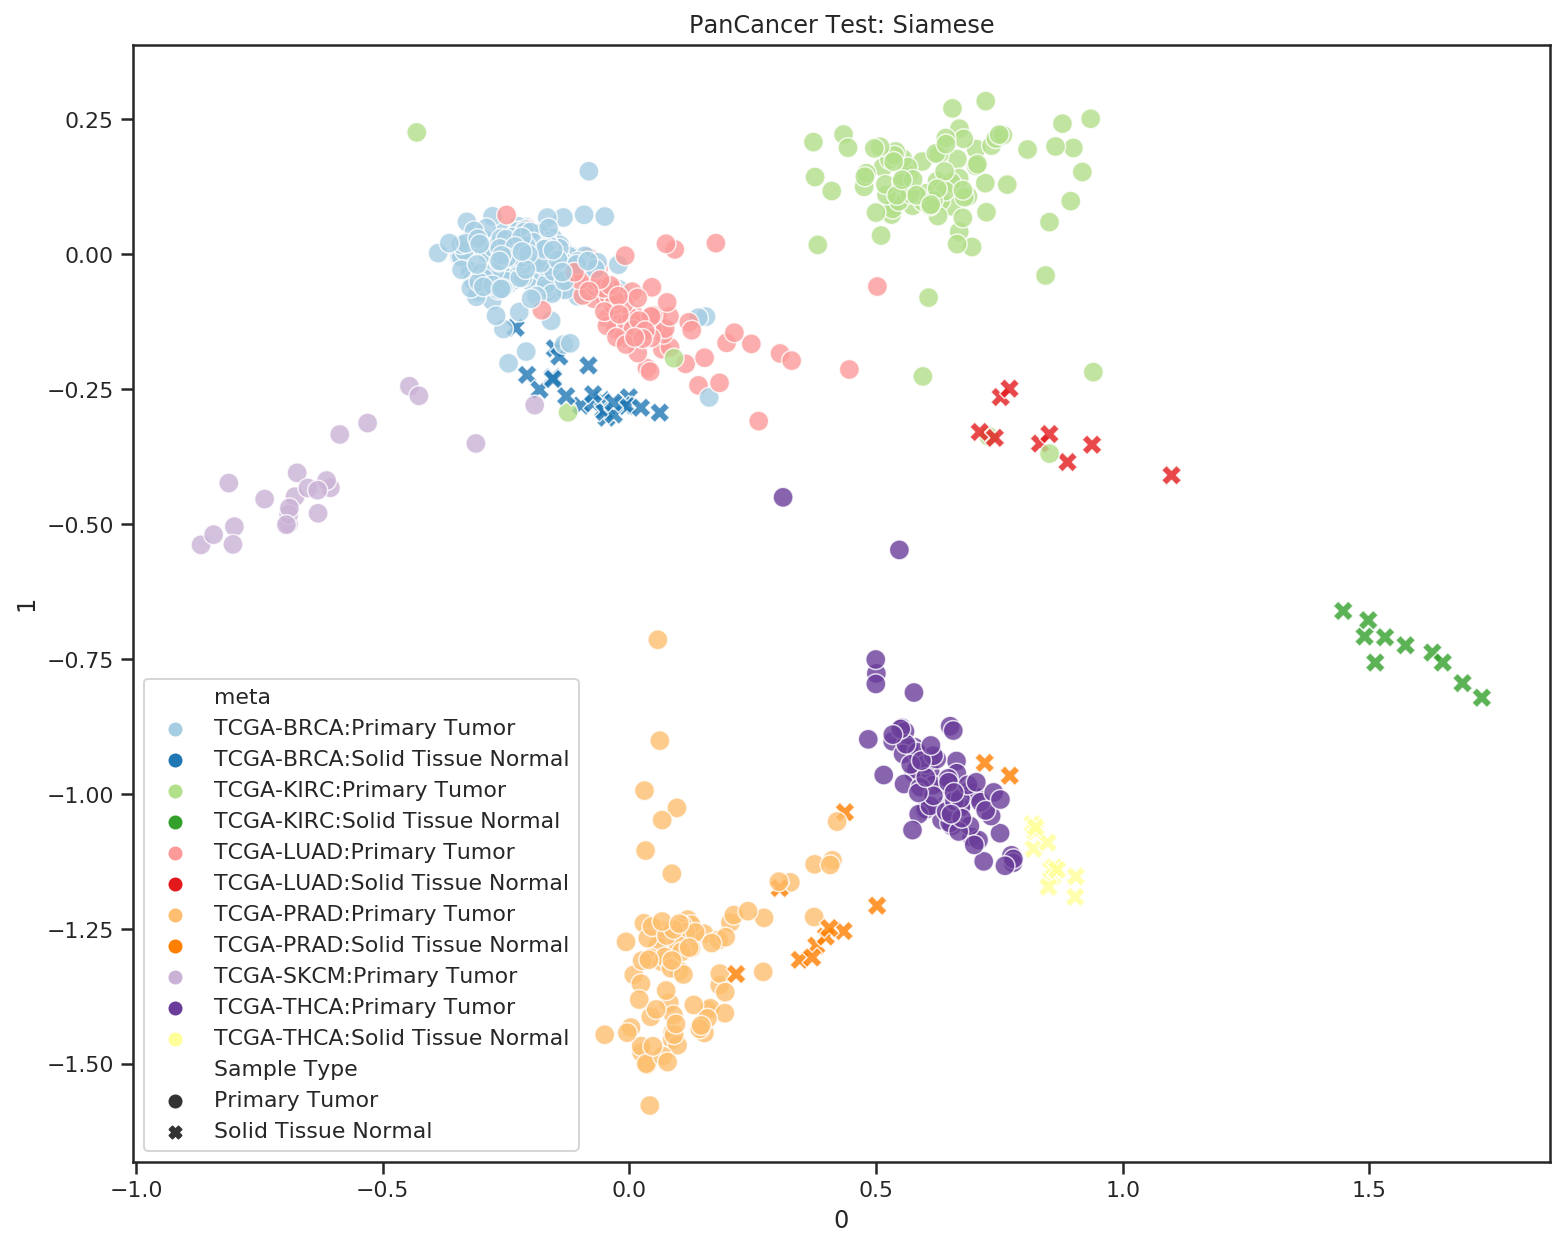

In [38]:
val_embeddings_baseline, val_labels_baseline = vis.extract_embeddings(test_loader, model)
vis.sns_plot_embeddings(val_embeddings_baseline, val_labels_baseline, siamese_test_dataset, hue='meta', style='Sample Type')
plt.title('PanCancer Test: Siamese')

## Save Model

In [39]:
save = False
if save:
    torch.save(model.state_dict(), "../../data/TCGA/models/220_seminar_results.pt")

## Kmeans Cluster and NMI Evaluation

In [40]:
from sklearn.cluster import KMeans
from sklearn.metrics import normalized_mutual_info_score as NMI
from sklearn.metrics import adjusted_mutual_info_score as aNMI

In [41]:
n_clusters = len(siamese_test_dataset.meta_dict) - len(exp.holdout)
kmeans = KMeans(n_clusters=n_clusters, random_state=0)
siamese_clusters = kmeans.fit_predict(val_embeddings_baseline)

In [42]:
aNMI(siamese_clusters, val_labels_baseline)

0.7552976077451952

In [43]:
# class Experiment():
#     """
#     Defines an experimental class hierarchy object.
#     """
#     def __init__(self, samples_dir, hierarchy, cases, min_samples):
#         assert isinstance(hierarchy, OrderedDict), "Argument of wrong type."
#         self.samples_dir = samples_dir
#         self.hierarchy = hierarchy
#         self.min_samples = min_samples
#         self.data = self.load_data(self.samples_dir)
#         self.cases = self.data[cases].unique()
        
#     def load_data(self, samples_dir):
#         samples = pd.read_csv(samples_dir, sep="\t")
#         samples['data'] = [val[1] for i,val in samples['File Name'].str.split(".").items()]
#         return samples
    
#     def process_data(self):
#         # downsample data
#         for key,val in self.hierarchy.items():
#             self.samples = self.data[self.data[key].isin(val)].copy()
#         # unique meta classes
#         self.samples['meta'] = self.samples[list(hierarchy.keys())].apply(lambda row: ':'.join(row.values.astype(str)), axis=1)
#         # filter meta classes
#         meta_counts = self.samples['meta'].value_counts()
#         meta_keep = meta_counts[meta_counts > self.min_samples].index
#         self.samples = self.samples[self.samples['meta'].isin(meta_keep)]
#         # generate class categories
#         self.samples['meta'] = self.samples['meta'].astype('category')
#         self.meta = {key:val for key,val in enumerate(self.samples['meta'].cat.categories.values)}

## Project Metastatic SKCM

In [44]:
# proj_hierarchy = OrderedDict({'Project ID':['TCGA-SKCM'],
#                               'Sample Type':['Metastatic']})

In [45]:
# Need to define Experiment method for use in adding classes for projection
# because categorical classes are predefined, need to add an additional class based
# on these numerical labels
# this will probably be helpful with plotting also...

In [46]:
# proj = Experiment(samples_dir='../../data/TCGA/rna-seq_pan/meta/gdc_sample_sheet.2019-12-12.tsv',
#                  hierarchy=proj_hierarchy,
#                  cases='Case ID',
#                  min_samples=20)

In [47]:
proj_dataset = TCGA(root_dir, samples=exp.holdout_samples, meta_dict=exp.meta_dict, train=False, target=target, log=True)
proj_dataset.featurize(HGNC=HGNC, features='all', proteins_only=True)

In [48]:
proj_dataset.data = pd.DataFrame(scaler.transform(proj_dataset.data),
                                 index=proj_dataset.data.index,
                                 columns=proj_dataset.data.columns)

In [49]:
# Still required in order to feed single samples for embedding extraction
batch_size = 1
kwargs = {'num_workers': 10, 'pin_memory': True} if cuda else {'num_workers': 10}
proj_loader = torch.utils.data.DataLoader(proj_dataset, batch_size=batch_size, shuffle=False, **kwargs)

In [50]:
proj_embeddings_baseline, proj_labels_baseline = vis.extract_embeddings(proj_loader, model)

Text(0.5, 1.0, 'PanCancer Test: Siamese')

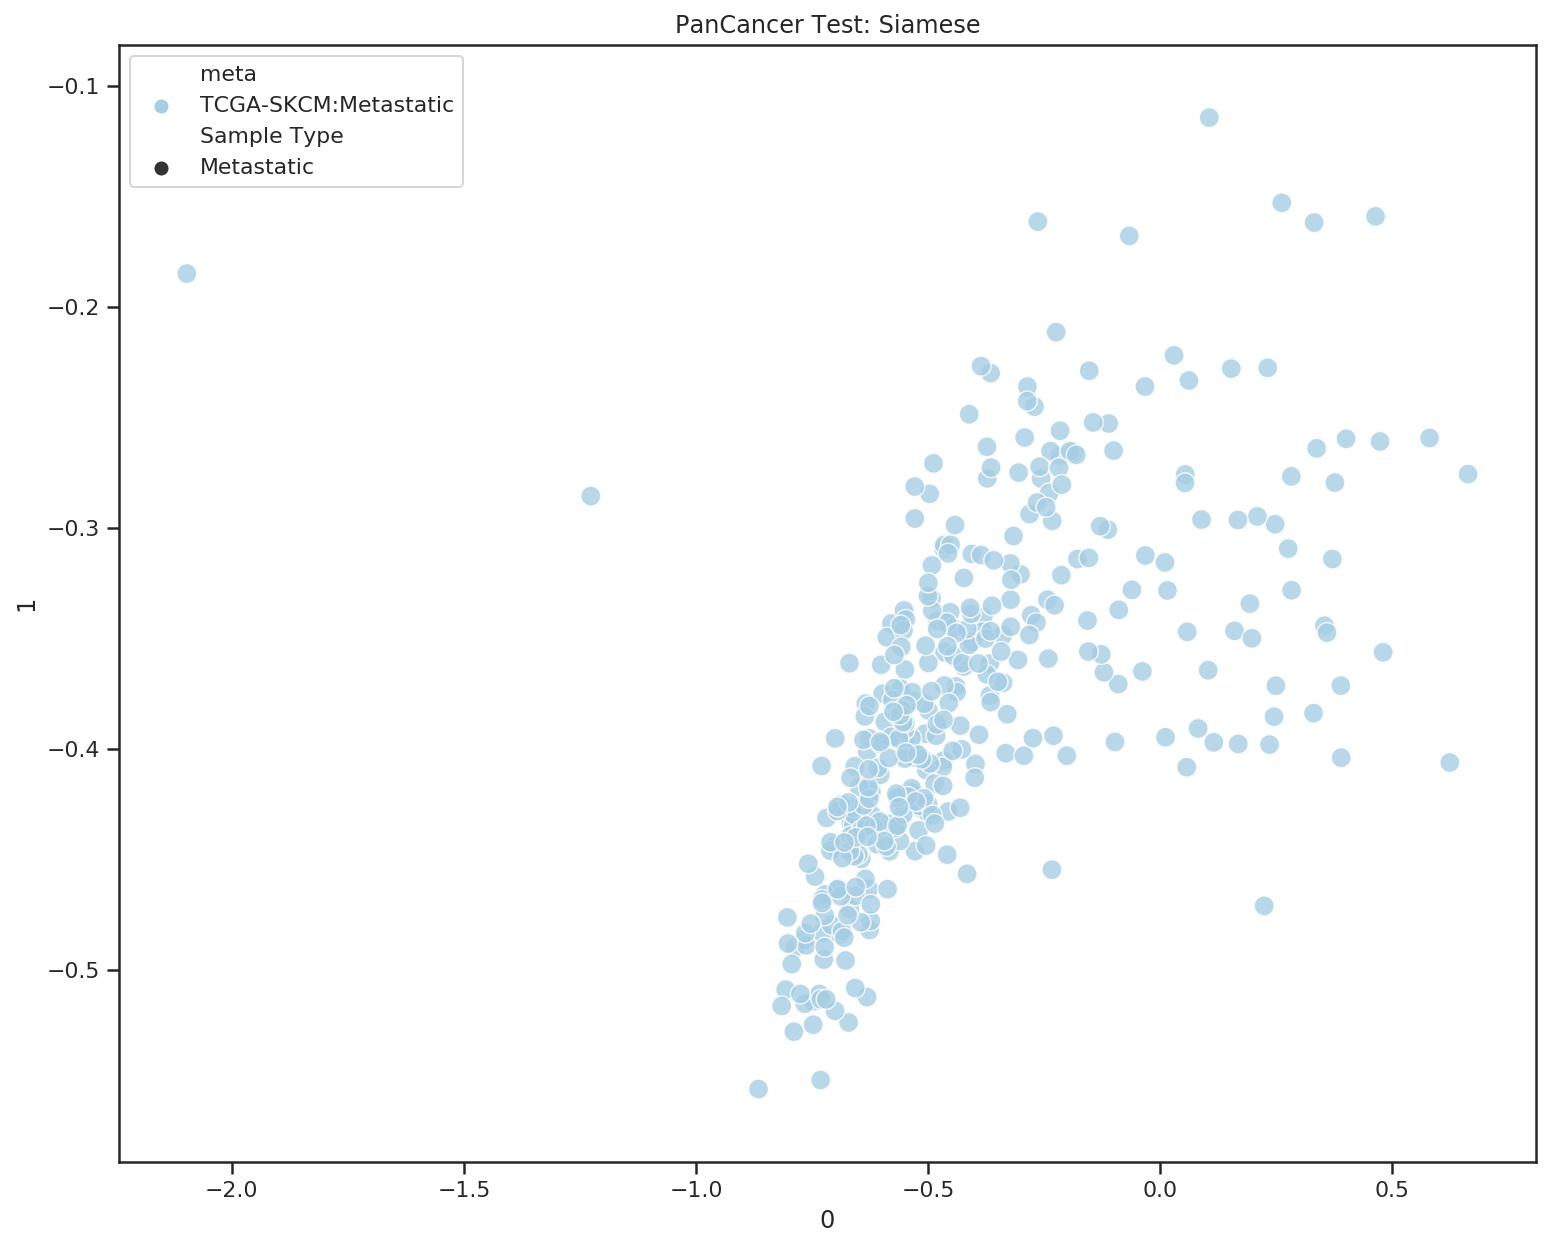

In [51]:
vis.sns_plot_embeddings(proj_embeddings_baseline, proj_labels_baseline, proj_dataset, hue='meta', style='Sample Type')
plt.title('PanCancer Test: Siamese')

In [52]:
val_labels_baseline

array([ 0.,  0., 10.,  6.,  6.,  6.,  1.,  2.,  0., 10., 10.,  0.,  4.,
        0.,  9.,  2., 10.,  1.,  4.,  0.,  0.,  0.,  2.,  2.,  0.,  9.,
        0.,  6.,  0.,  6.,  4.,  0.,  1.,  0.,  0.,  1.,  0.,  0.,  0.,
        0., 11.,  4.,  2.,  0.,  4., 11.,  6.,  0.,  6.,  1.,  2.,  6.,
        0.,  0.,  0.,  2.,  0.,  6.,  1.,  2., 10.,  6.,  4.,  0.,  0.,
        0.,  1.,  6., 10.,  0.,  2.,  4., 10.,  2.,  0.,  1., 10.,  0.,
        0.,  2.,  6.,  2.,  6.,  0.,  2., 10.,  4.,  4.,  7.,  9.,  0.,
        0., 10.,  6.,  0.,  0.,  4., 10.,  0.,  4.,  2.,  2.,  6., 10.,
        0.,  0.,  3.,  3.,  0., 10.,  2.,  0.,  2.,  6., 10., 10.,  3.,
        6.,  0., 10.,  2.,  0.,  4.,  0.,  0.,  0.,  4.,  4.,  0.,  4.,
        4.,  0.,  0.,  6.,  1.,  4.,  0.,  2.,  6.,  2., 10.,  0.,  0.,
        0.,  4.,  4.,  2.,  6.,  0.,  2.,  2.,  2.,  0.,  7.,  4.,  7.,
        4., 10.,  0.,  0.,  0.,  6.,  0.,  2.,  6.,  0.,  0.,  9.,  6.,
        5.,  1.,  0.,  2.,  2.,  6.,  7.,  0.,  0.,  0.,  0.,  0

In [53]:
proj_labels_baseline

array([8., 8., 8., 8., 8., 8., 8., 8., 8., 8., 8., 8., 8., 8., 8., 8., 8.,
       8., 8., 8., 8., 8., 8., 8., 8., 8., 8., 8., 8., 8., 8., 8., 8., 8.,
       8., 8., 8., 8., 8., 8., 8., 8., 8., 8., 8., 8., 8., 8., 8., 8., 8.,
       8., 8., 8., 8., 8., 8., 8., 8., 8., 8., 8., 8., 8., 8., 8., 8., 8.,
       8., 8., 8., 8., 8., 8., 8., 8., 8., 8., 8., 8., 8., 8., 8., 8., 8.,
       8., 8., 8., 8., 8., 8., 8., 8., 8., 8., 8., 8., 8., 8., 8., 8., 8.,
       8., 8., 8., 8., 8., 8., 8., 8., 8., 8., 8., 8., 8., 8., 8., 8., 8.,
       8., 8., 8., 8., 8., 8., 8., 8., 8., 8., 8., 8., 8., 8., 8., 8., 8.,
       8., 8., 8., 8., 8., 8., 8., 8., 8., 8., 8., 8., 8., 8., 8., 8., 8.,
       8., 8., 8., 8., 8., 8., 8., 8., 8., 8., 8., 8., 8., 8., 8., 8., 8.,
       8., 8., 8., 8., 8., 8., 8., 8., 8., 8., 8., 8., 8., 8., 8., 8., 8.,
       8., 8., 8., 8., 8., 8., 8., 8., 8., 8., 8., 8., 8., 8., 8., 8., 8.,
       8., 8., 8., 8., 8., 8., 8., 8., 8., 8., 8., 8., 8., 8., 8., 8., 8.,
       8., 8., 8., 8., 8.

In [33]:
def sns_plot_embeddings(embeddings, labels, classes, hue, style):
    sns.set_style("ticks")
    id_map = {key:val for key,val in enumerate(classes)}
    data = np.concatenate([embeddings, labels.reshape(-1,1)], axis=1)
    data = pd.DataFrame(data, columns=[0,1,'label'])
    data['label'] = data['label'].astype(int)
    data['meta'] = data['label'].map(id_map).astype('category')
    data[style] = [i[1] for i in data['meta'].str.split(":")]
    # plot
    sns.scatterplot(x=0, y=1, hue=hue, style=style, palette="Paired", data=data,
                s=100, alpha=0.8)

array([[ 0.01844633,  0.14667846],
       [ 0.99739736,  0.20096214],
       [ 0.35751557, -0.01188277],
       [ 0.71800441,  0.14909534],
       [ 3.13813281, -0.04743893],
       [-0.11343524, -0.10713048],
       [-0.69335181, -0.61581057],
       [-3.18737006, -1.60202456],
       [ 0.70152521,  0.15903249],
       [ 0.67064673,  0.06805937],
       [ 2.42193365,  1.12988317],
       [-0.20719036, -0.40494579],
       [ 2.78704667,  0.19412507],
       [ 2.05397487,  0.17520286],
       [ 0.20583174, -0.02541065],
       [ 4.11072874, -0.56046861],
       [ 1.223248  ,  0.89214164],
       [-1.60554695, -0.73626381],
       [-0.74559498, -0.29455209],
       [ 0.33941662,  0.30151355],
       [-0.75007427, -0.35947812],
       [ 0.20796733, -0.78800613],
       [-2.00242329, -0.72051579],
       [-0.22030723, -0.01685364],
       [ 4.00695324, -0.24569772],
       [ 0.16307485, -0.83896637],
       [ 2.59422183,  1.02771151],
       [ 1.61299825,  0.64942676],
       [-0.31509006,

## SKCM Clinical Info

In [597]:
skcm_clinical = pd.read_csv("../../data/TCGA/clinical/skcm/https:/api.gdc.cancer.gov/data/58cbbc07-5ec4-47c7-9295-11ccbf7693f4/nationwidechildrens.org_clinical_patient_skcm.txt", 
                            sep="\t")
# remove extra header
skcm_clinical = skcm_clinical.loc[2:, :].reset_index(drop=True)
skcm_clinical.shape

(470, 65)

In [598]:
skcm_metas_dist = skcm_clinical[skcm_clinical['primary_location'] == 'Distant Metastasis']
skcm_metas_dist = skcm_clinical[skcm_clinical['metastatic_tumor_site'] == 'Lung']
skcm_metas_dist.shape

(5, 65)

In [599]:
bool_skcm_metas_dist = projection_dataset.samples['Case ID'].isin(skcm_metas_dist['bcr_patient_barcode'])
bool_skcm_metas_dist.sum()

5

In [600]:
import seaborn as sns
sns.set(rc={'figure.figsize':(18.7,14.27)})

Text(0.5, 1.0, 'PanCancer Metastatic: Siamese')

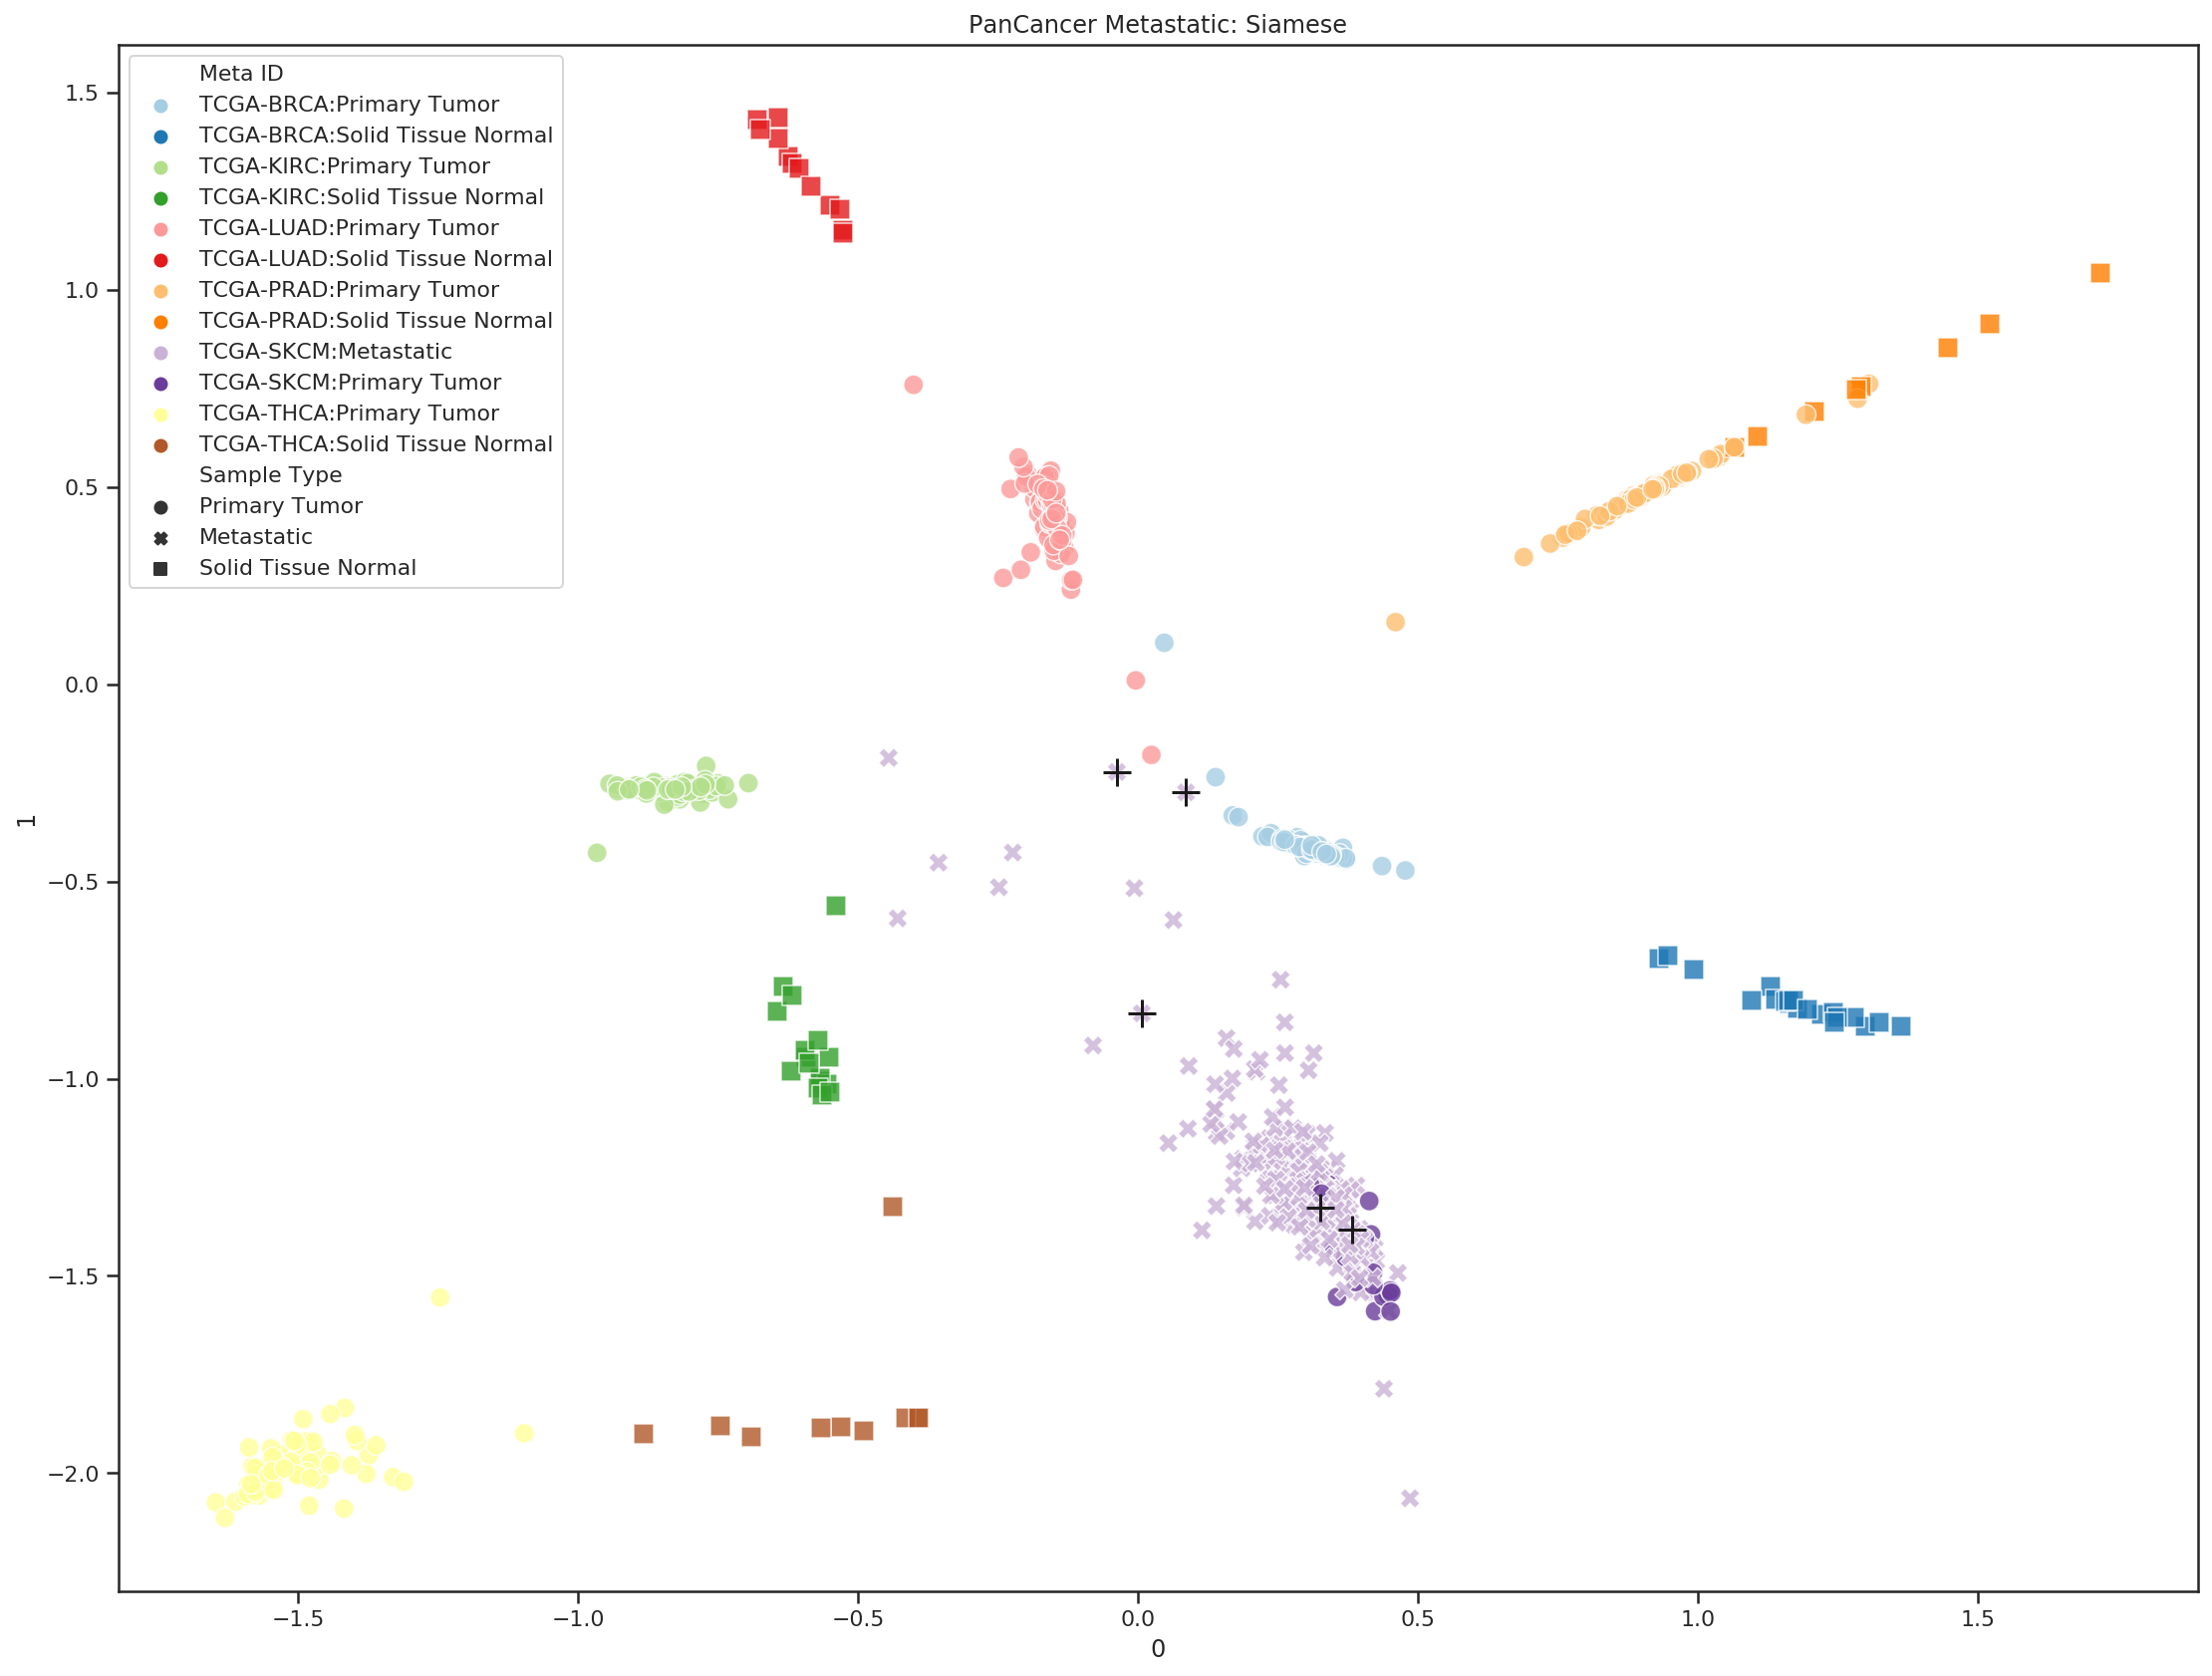

In [601]:
vis.sns_plot_embeddings(proj_embeddings_baseline, projection_dataset, hue='Meta ID', style='Sample Type')
plt.scatter(proj_embeddings_baseline[bool_skcm_metas_dist,0], 
            proj_embeddings_baseline[bool_skcm_metas_dist,1],
            marker="+", color='k', s=200)
plt.title('PanCancer Metastatic: Siamese')

## Project CCLE Cells
- no normalization or scaling done here...

In [602]:
ccle_meta = pd.read_csv("../../data/DepMap/sample_info_v2.csv", index_col=0)
ccle_meta.head()

,stripped_cell_line_name,CCLE_Name,alias,COSMIC_ID,lineage,lineage_subtype,lineage_sub_subtype,lineage_molecular_subtype,sex,source,Achilles_n_replicates,cell_line_NNMD,culture_type,culture_medium,cas9_activity,RRID,sample_collection_site,primary_or_metastasis,disease,disease_subtype,age,Sanger_model_ID,additional_info
DepMap_ID,,,,,,,,,,,,,,,,,,,,,,,
ACH-000001,NIHOVCAR3,NIHOVCAR3_OVARY,OVCAR3,905933.0,ovary,ovary_adenocarcinoma,high_grade_serous,NaN,Female,ATCC,NaN,NaN,NaN,NaN,NaN,CVCL_0465,ascites,Metastasis,Ovarian Cancer,"Adenocarcinoma, high grade serous",60.0,SIDM00105,NaN
ACH-000002,HL60,HL60_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE,NaN,905938.0,blood,AML,M3,NaN,Female,ATCC,NaN,NaN,NaN,NaN,NaN,CVCL_0002,haematopoietic_and_lymphoid_tissue,Primary,Leukemia,"Acute Myelogenous Leukemia (AML), M3 (Promyelo...",35.0,SIDM00829,NaN
ACH-000003,CACO2,CACO2_LARGE_INTESTINE,"CACO2, CaCo-2",NaN,colorectal,colorectal_adenocarcinoma,NaN,NaN,Male,ATCC,NaN,NaN,NaN,NaN,NaN,CVCL_0025,Colon,NaN,Colon/Colorectal Cancer,Adenocarcinoma,NaN,SIDM00891,NaN
ACH-000004,HEL,HEL_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE,NaN,907053.0,blood,AML,M6,NaN,Male,DSMZ,2.0,-3.079202,Suspension,RPMI-1640: 10%FBS,47.6,CVCL_0001,haematopoietic_and_lymphoid_tissue,NaN,Leukemia,"Acute Myelogenous Leukemia (AML), M6 (Erythrol...",30.0,SIDM00594,NaN
ACH-000005,HEL9217,HEL9217_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE,NaN,NaN,blood,AML,M6,NaN,Male,ATCC,2.0,-2.404409,Semi-adherent,RPMI; 10% FBS,13.4,CVCL_2481,bone_marrow,NaN,Leukemia,"Acute Myelogenous Leukemia (AML), M6 (Erythrol...",30.0,SIDM00593,NaN


In [603]:
msys = ['Lung Cancer', 'Breast Cancer', 'Kidney Cancer', 'Prostate Cancer', 'Skin Cancer', 'Thyroid Cancer']
ccle_meta_sub = ccle_meta[ccle_meta['disease'].isin(msys)]
ccle_meta_sub.shape

(547, 23)

In [604]:
# get shared protein subset to training data
ccle_overlap_idx = ccle.columns.isin(train_dataset.data.columns)
ccle = ccle.loc[:, ccle_overlap_idx]

In [605]:
# reorder columns to match training columns
ccle = ccle[train_dataset.data.columns]
assert np.array_equal(ccle.columns.values, train_dataset.data.columns.values)

In [606]:
# reorder rows to match data and meta data
ccle_sub = ccle.loc[ccle_meta_sub.index,:]
assert np.array_equal(ccle_meta_sub.index, ccle_sub.index)

/srv/home/wconnell/anaconda3/envs/torch/lib/python3.7/site-packages/pandas/core/indexing.py:1418: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


In [607]:
from tcga_datasets import CCLE
ccle_dataset = CCLE(ccle_sub, ccle_meta_sub, train=False, log=True)
ccle_dataset.data.head()

,TSPAN6,TNMD,DPM1,SCYL3,C1orf112,FGR,CFH,FUCA2,GCLC,NFYA,STPG1,NIPAL3,LAS1L,ENPP4,SEMA3F,CFTR,ANKIB1,CYP51A1,KRIT1,RAD52,BAD,LAP3,CD99,HS3ST1,AOC1,WNT16,HECW1,MAD1L1,LASP1,SNX11,TMEM176A,M6PR,KLHL13,CYP26B1,ICA1,DBNDD1,ALS2,CASP10,CFLAR,TFPI,NDUFAF7,RBM5,MTMR7,SLC7A2,ARF5,SARM1,POLDIP2,PLXND1,AK2,CD38,FKBP4,KDM1A,RBM6,CAMKK1,RECQL,VPS50,HSPB6,ARHGAP33,NDUFAB1,PDK4,SLC22A16,ZMYND10,ABCB5,ARX,SLC25A13,ST7,CDC27,SLC4A1,CALCR,HCCS,DVL2,PRSS22,UPF1,SKAP2,SLC25A5,MCUB,HOXA11,POLR2J,DHX33,MEOX1,THSD7A,LIG3,RPAP3,ACSM3,REXO5,CIAPIN1,SPPL2B,FAM214B,COPZ2,PRKAR2B,MSL3,CREBBP,TSPOAP1,MPO,PON1,GCFC2,WDR54,CROT,ABCB4,KMT2E,RHBDD2,SOX8,IBTK,ZNF195,MYCBP2,FBXL3,ITGAL,PDK2,ITGA3,ZFX,LAMP2,ITGA2B,ASB4,GDE1,REX1BD,CRLF1,OSBPL7,TMEM98,YBX2,KRT33A,MAP3K14,ABCC8,CACNG3,TMEM132A,AP2B1,TAC1,ZNF263,CX3CL1,SPATA20,CACNA1G,TNFRSF12A,DLX6,MAP3K9,RALA,BAIAP2L1,KDM7A,ETV1,AGK,ALDH3B1,TTC22,PHTF2,CCL26,FARP2,USH1C,GGCT,DBF4,TBXA2R,IFRD1,LGALS14,COX10,GTF2IRD1,PAF1,VPS41,ARHGAP44,ELAC2,SCIN,ARSD,PNPLA4,MYH13,ADIPOR2,CDKL3,UPP2,PRSS21,MARK4,PROM1,CCDC124,CEACAM21,PAFAH1B1,NOS2,DNAH9,KIAA0100,SLC13A2,TRAPPC6A,MATK,CEACAM7,CD79B,ST7L,TKTL1,PAX6,RPUSD1,RHBDF1,LUC7L,CACNA2D2,BAIAP3,TSR3,PIGQ,CRAMP1,TEAD3,SELE,DNAJC11,FMO3,MYLIP,NOX1,E2F2,PSMB1,SYN1,JARID2,CDKL5,CAMK1G,CDK11A,NADK,TFAP2B,DLEC1,CYTH3,ADAM22,SYPL1,CYB561,SPAG9,CELSR3,AASS,PLEKHG6,SS18L2,MPND,MGST1,CRY1,PGLYRP1,NFIX,ST3GAL1,MMP25,IL32,PKD1,MAPK8IP2,MED24,RHOBTB2,HEATR5B,SEC62,RPS20,CSDE1,UBE3C,REV3L,TENM1,PAX7,MASP2,IYD,FAM76A,TRAF3IP3,POMT2,VTA1,MLXIPL,BAZ1B,RANBP9,ETV7,SPRTN,DYRK4,ZNF207,UQCRC1,STARD3NL,CD9,HHATL,NCAPD2,IFFO1,GIPR,PHF7,SEMA3G,NISCH,STAB1,FUZ,SLC6A13,IDS,PRSS3,ZNF200,CD4,LRRC23,BTK,HFE,SCMH1,FYN,HIVEP2,FMO1,ELOA,LYPLA2,CLCN6,MRC2,SLC6A7,TSPAN9,BTBD7,APBA3,MKS1,ABHD5,ANOS1,AKAP8L,MBTD1,UTP18,RNF216,TTC19,PTBP1,DPF1,SYT7,LARS2,PIK3C2A,PLAUR,ANLN,WIZ,RABGAP1,DCN,QPCTL,PPP5C,CEP68,MAP4K3,ZBTB32,TYROBP,TMEM159,GABRA3,BRCA1,ERCC1,CD22,SEMA3B,MBTPS2,PRICKLE3,LTF,EXTL3,NR1H4,ELOVL5,ALOX5,KDM5D,CALCOCO1,UBR7,MAP4K5,EHD3,PSMC4,MAN2B2,SLC7A14,CLDN11,SLC25A39,MVP,NUB1,PGM3,RWDD2A,CLK1,POLR3B,ANGEL1,RNF14,DNASE1L1,DDX11,HEBP1,GPRC5A,MAMLD1,CD6,TACC3,UFL1,POLA2,ZC3H3,CAPN1,MDH1,SLC30A9,MTMR11,COX15,CCDC88C,YAF2,ZMYND11,WAS,DPEP1,BID,MATR3,NPC1L1,XYLT2,RGPD5,STMN4,NUDCD3,ISL1,CHDH,IL20RA,CLCA1,CLCA4,GLT8D1,ATP2C1,IGF1,SLC38A5,RALBP1,RUFY3,CNTN1,SLC11A1,WWTR1,AGPS,CXorf56,ATP1A2,TTC27,ZNF582,VSIG2,PHLDB1,MARCO,CYP24A1,PRDM11,SYT13,SNAI2,CD74,HGF,ZRANB1,NCDN,ADGRA2,ZFP64,MNAT1,SAMD4A,RUNX3,MRE11,PLEKHB1,SERPINB1,CYP3A43,SLC7A9,SPAST,NRXN3,OSBPL5,AQR,CPS1,C8B,FHL1,RTF2,GABRA1,NLRP2,SLC45A4,RNF10,ZNF839,ZDHHC6,GRAMD1B,RNH1,NDUFS1,RB1CC1,ERP44,ALAS1,BIRC3,AKAP11,GLRX2,SNAPC1,DERA,STRAP,ABCC2,DEF6,PLEKHO1,GCLM,UBR2,EHD2,DEPDC1,CCDC28A,RRAGD,HSF2,PHF20,HSD17B6,NR1H3,TYMP,NCAPH2,TOMM34,SEC63,KPNA6,VIM,FAS,RNASET2,CD44,KCNG1,AGPAT4,SLAMF7,BTN3A1,MIPEP,PRKCH,INSRR,IFNGR1,B4GALT7,SH2D2A,VRK2,TNFRSF1B,VEZT,POU2F2,BRD9,SNX1,TBPL1,ARNTL2,BCLAF1,SLC39A9,ANK1,IBSP,TFB1M,HMGB3,NUP160,BAK1,MUSK,IKZF2,GRN,FAM13B,ARHGAP31,CENPQ,RANBP3,ARID4A,EIPR1,IFT88,ALG1,ABCF2,CHPF2,LRRC7,FUT8,UBA6,GAB2,ATP6V0A1,PIAS1,SLC4A7,APBA2,MAP2K3,EFCAB1,TMSB10,ASTE1,RNF19A,PEX3,...,BORCS8,DPP3,KRTAP5-9,BRK1,UBTFL1,PIGY,OR1D4,CHMP1B,EID3,GLYATL1B,HTD2,CCDC166,NANOGP8,CARD17,PRR23D1,SMIM35,OR8G5,EID1,OR52B2,NOX5,CCDC179,PRR23D2,OOSP4B,HCAR3,EBLN2,CARD18,NPIPB8,POLR2M,FDXACB1,OR10G2,RAB44,TRIL,OR4D2,OR6J1,MTRNR2L8,TIFAB,TAS2R20,CYP2A6,CTSO,MTRNR2L10,TRAPPC2B,DNAAF4,SMLR1,MTRNR2L3,ZNF10,ZNF486,SMIM3,HMBS,PPIAL4D,ASIC5,DND1,SALL3,POLG2,SMIM10L1,OR13A1,MTRNR2L1,CLEC12B,LIMS4,ZNF350,PGA5,STH,ZNF253,KLRF2,C17orf100,CAPNS2,SLC5A8,MTRNR2L7,LIMS3,KHDC1L,GPR142,HP,C11orf97,LSM14A,NHLRC4,OR11H12,TAS2R38,GATC,ZBED6,MGAM,FNTB,ZNF878,ZNF625,GALNT4,INAFM1,CNPY2,MGAM2,CUX1,TEN1,TEX49,OR9A4,MAP1LC3B2,PRSS58,CLEC5A,CHURC1,C17orf49,RTEL1,ZNF578,PDF,RNASE12,OR11H2,SERPINA2,TRIM34,C20orf141,OR11H7,OR4C13,RNASE4,MC1R,DUXA,CEP95,TUBB3,TMEM179,TSPY1,SMIM6,ITGB3,INAFM2,GH1,CTXND1,THTPA,MRPL46,BLID,SLC22A31,LYPD8,RBM15B,TGFBR3L,HOXB7,SPDYE6,CCDC187,FRRS1L,ARMH2,TBC

In [608]:
ccle_scaler = StandardScaler()
ccle_dataset.data = pd.DataFrame(ccle_scaler.fit_transform(ccle_dataset.data),
                                  index=ccle_dataset.data.index,
                                  columns=ccle_dataset.data.columns)

In [609]:
ccle_loader = torch.utils.data.DataLoader(ccle_dataset, batch_size=batch_size, shuffle=False, **kwargs)

In [610]:
ccle_embeddings_baseline, ccle_labels_baseline = vis.extract_embeddings(ccle_loader, model)

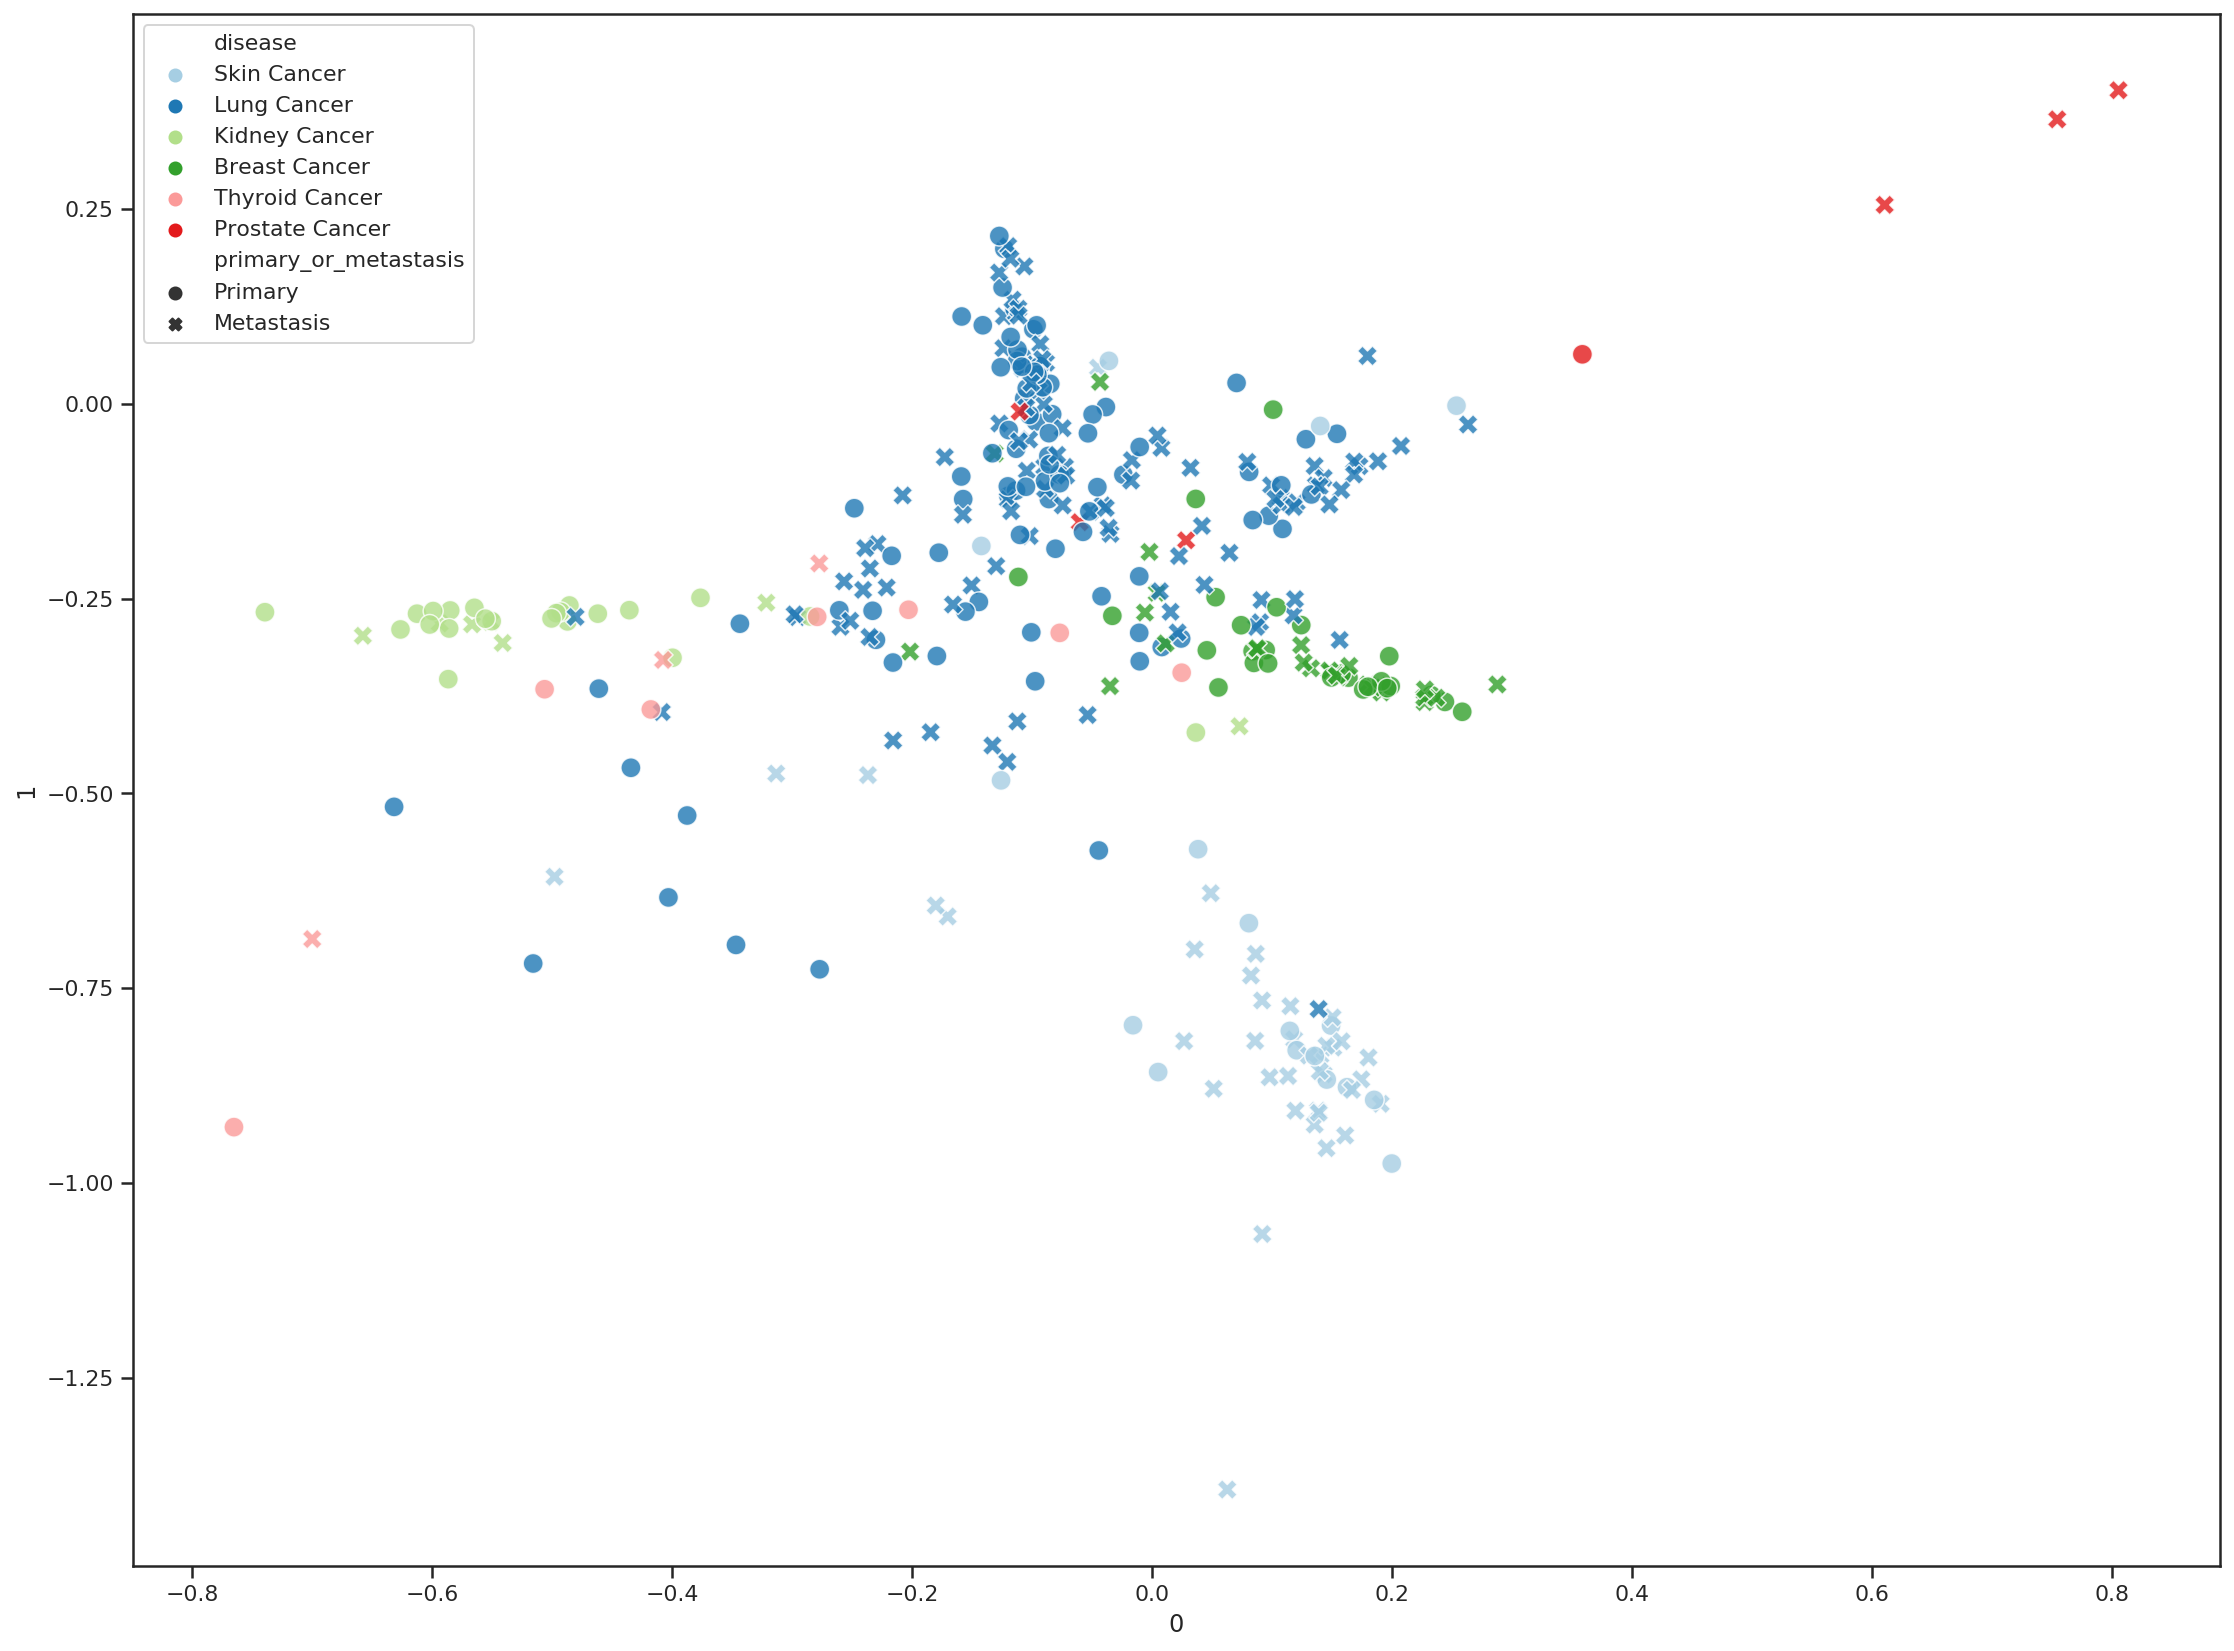

In [611]:
vis.sns_plot_embeddings(ccle_embeddings_baseline, ccle_dataset, hue="disease", style="primary_or_metastasis")